## Using the Stereo Convolution (SOLP)

In this experiment the layer SOLP is used. This layer allows the network to learn the optimal disparity (the overlap distance) of a SIRDS. The layer receives as input an image and produces as output a set of feature maps, each one with a different overlap. 

To achieve this goal, a constrained convolution called stereo convolution operation is defined (more information in the paper).

In [1]:
import sys
sys.path.append("../src")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import keras
from models import classifly_with_stereoconv_layer
from generators import CommonImagesGenerator
from livelossplot import PlotLossesKerasTF
from utils import show_sampledata, show_features, get_sample_feature_maps_importance
from matplotlib import pyplot as plt
import seaborn as sns
from keras.models import Model
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
model, train_gen, val_gen = classifly_with_stereoconv_layer()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stereo_conv (StereoConv)     (None, 200, 100, 200)     2         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 100, 200)     800       
_________________________________________________________________
conv2d (Conv2D)              (None, 198, 98, 32)       57632     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 96, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 17, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 15, 32)        9

We can see that we have reduced the number of paramater of the model from 3.000.000 of the previous experiment to ~720.000 parameters.

The SOLP layer only will need to learn two paramater: the levels of transparency of the overlapping.

The training data is the same that the former experiment.

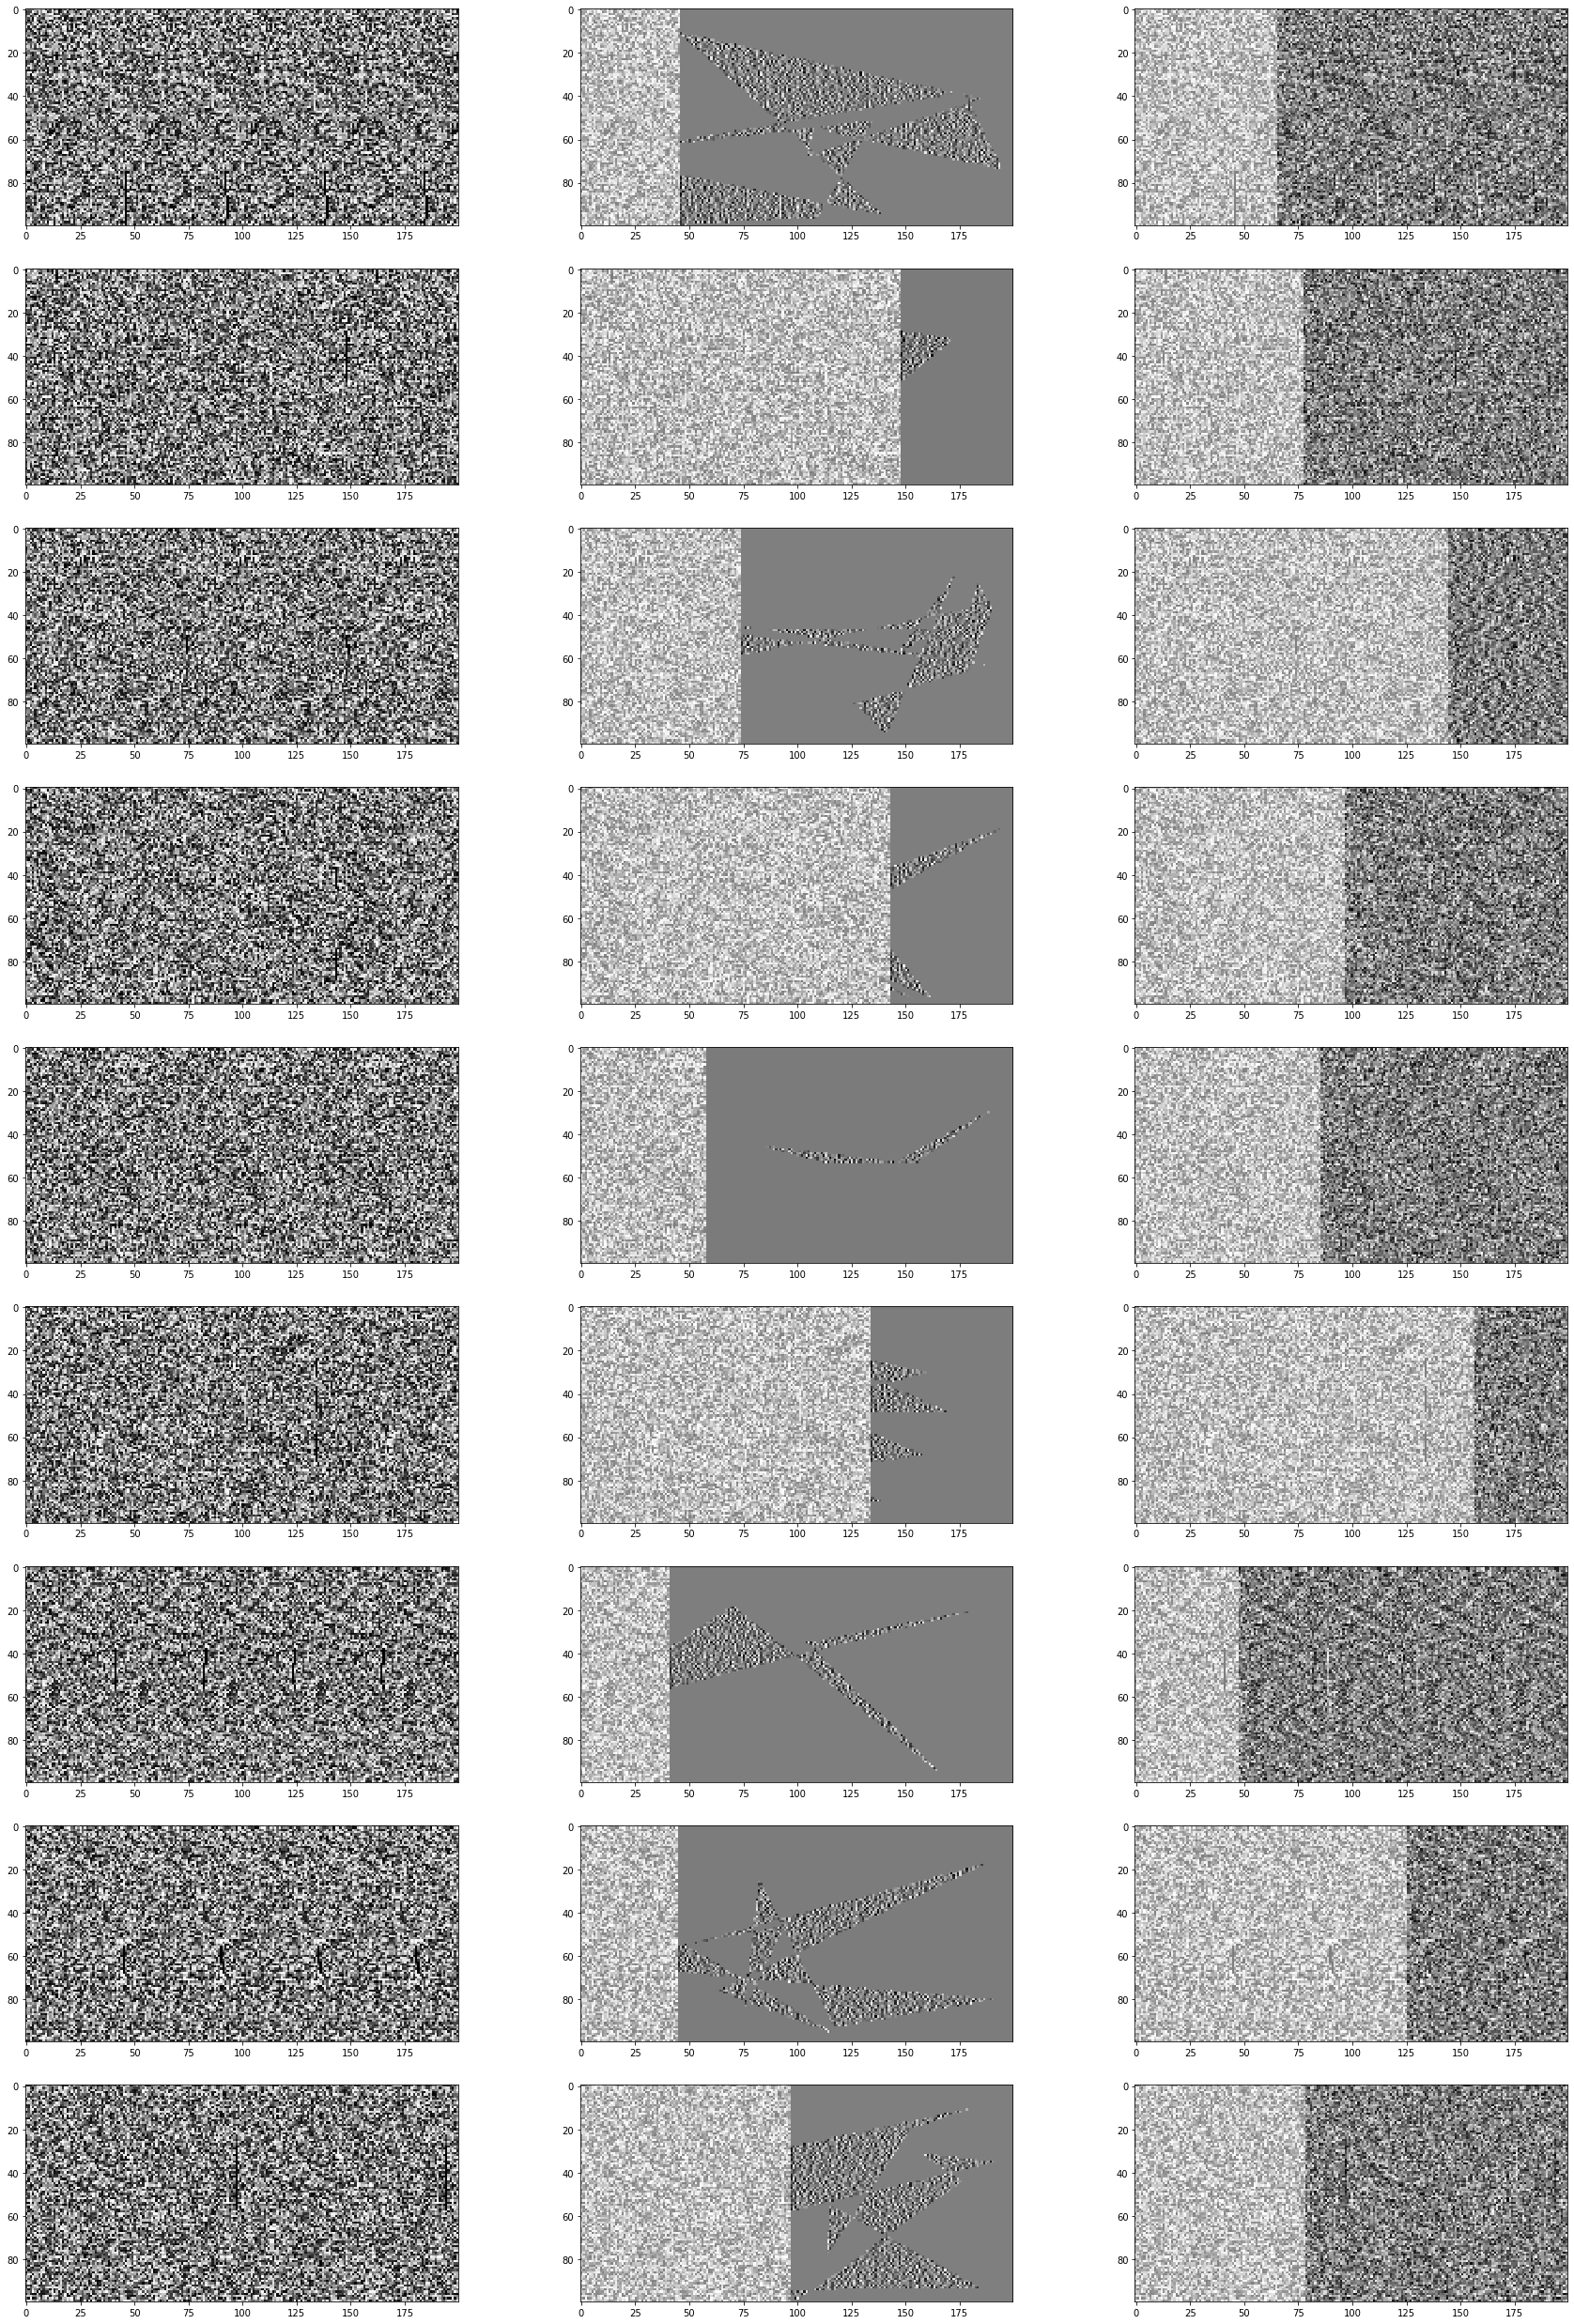

In [7]:
show_sampledata(train_gen)
plt.show()

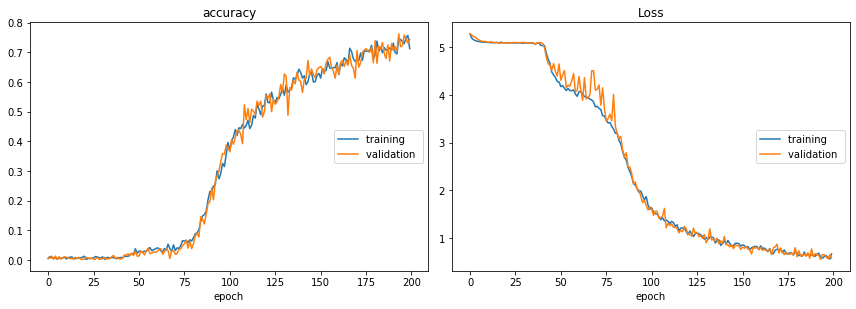

accuracy
	training         	 (min:    0.001, max:    0.757, cur:    0.713)
	validation       	 (min:    0.002, max:    0.762, cur:    0.744)
Loss
	training         	 (min:    0.558, max:    5.281, cur:    0.665)
	validation       	 (min:    0.548, max:    5.285, cur:    0.579)
31/31 [==============================] - 41s 1s/step - loss: 0.6654 - accuracy: 0.7127 - val_loss: 0.5793 - val_accuracy: 0.7437


In [56]:
model.fit_generator(generator=train_gen, validation_data=val_gen,
                    epochs=200, verbose=1, callbacks=[PlotLossesKerasTF()])

In [ ]:
model.save('../checkpoints/stero_class.h5')

In this case the model have been able to learn to classify the disparity factor with a high probability.

Was expected the model learnt a transparence level arround the 50% to apply the stereo convolution. With the factor of transparency is known that the silhouette is well seen. However, if we check the learnt parameters we found they are far of this expectations:

In [13]:
model.layers[0].weights

[<tf.Variable 'stereo_conv_2/stereo_conv_w1:0' shape=(1,) dtype=float32, numpy=array([-0.03582506], dtype=float32)>,
 <tf.Variable 'stereo_conv_2/stereo_conv_w2:0' shape=(1,) dtype=float32, numpy=array([-0.00105254], dtype=float32)>]

It might be easy to think that the model have been overfitted to the geometry of the training samples (remember that the training samples were composed by random polygons). To validate if the model have been overfitted we will use fresh set of real figures.

That figures are images of 10 differents animals (elephants, ants, spiders, eagles, ...). In the image the auto-stereograms (left column), the silhouette (center column) that can be seen when the auto-stereogram is solved and the non-solved auto-stereograms because a incorrect disparity is used are shown:

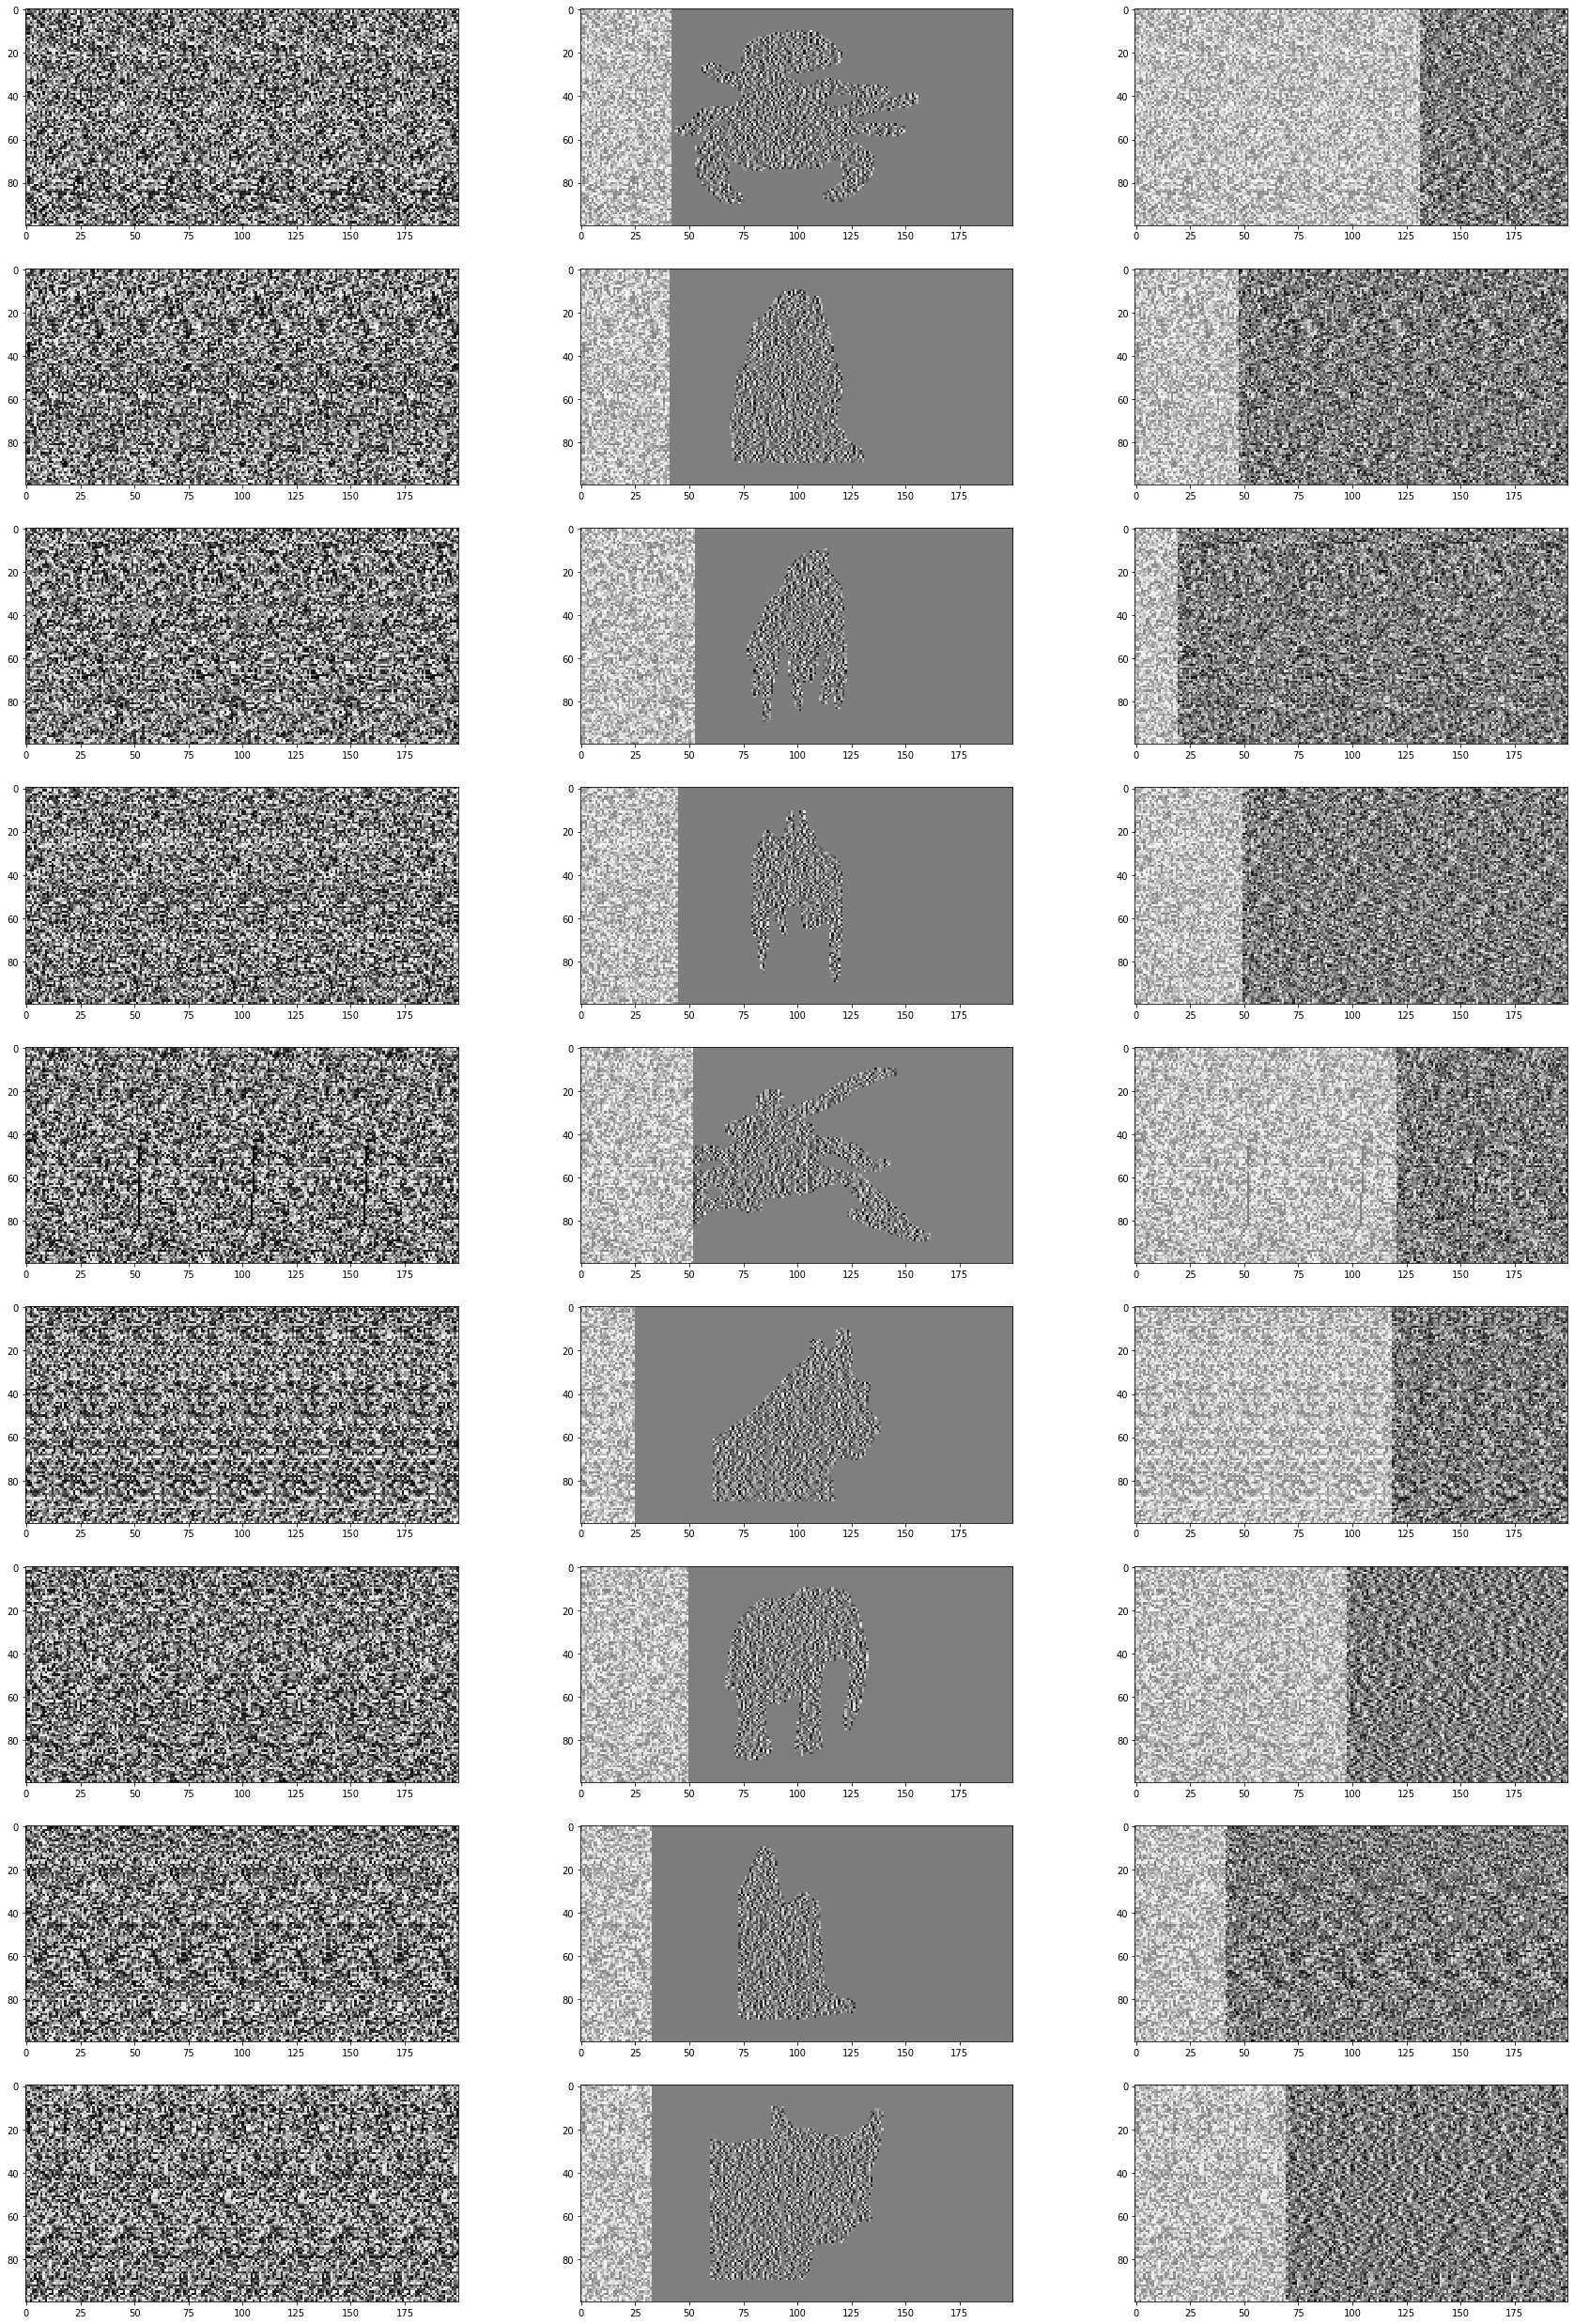

In [10]:
test_gen = CommonImagesGenerator('../data/fake_heatmaps/')
show_sampledata(test_gen)
plt.show()

In [51]:
test_gen = CommonImagesGenerator('../data/fake_heatmaps/')
classes = test_gen.classes
for klass in classes:
    test_gen = CommonImagesGenerator('../data/fake_heatmaps/', classes=[klass])
    loss, acc = model.evaluate(test_gen, verbose=0)
    print('%s class. Loss: %.4f  Accuracy: %.4f' % (klass, loss, acc))

ant class. Loss: 0.0113  Accuracy: 1.0000
bear class. Loss: 0.2377  Accuracy: 0.9618
crab class. Loss: 0.0049  Accuracy: 1.0000
eagle class. Loss: 0.2292  Accuracy: 0.9306
elephant class. Loss: 0.4555  Accuracy: 0.8795
lion class. Loss: 0.3549  Accuracy: 0.9312
lynx class. Loss: 0.2636  Accuracy: 0.9323
rabbit class. Loss: 0.1238  Accuracy: 0.9557
scorpion class. Loss: 0.0198  Accuracy: 0.9931
spider class. Loss: 0.0462  Accuracy: 0.9812


As can be seen the model have a excellent behaviour with this fresh dataset. So, can be concluded that the model have not been overfitted. 

The question now is: why that learnt parameters are good enough for the model? The feature maps of the SOLP layer will be shown to try get some clue.

We will select a random sample of the spider class:

In [21]:
batch = CommonImagesGenerator('../data/fake_heatmaps/', classes=['spider']).__getitem__(0)

sirds, y_true, disparity = batch[0][0], batch[1][0], np.where(batch[1][0] == 1)[0][0]
disparity

55

In [22]:
pred_disparity = model.predict(np.array([sirds])).argmax()
pred_disparity

55

In this case model has been able to find the correct disparity. We will get the feature maps and see if there is something especial in that feature map or near of it:

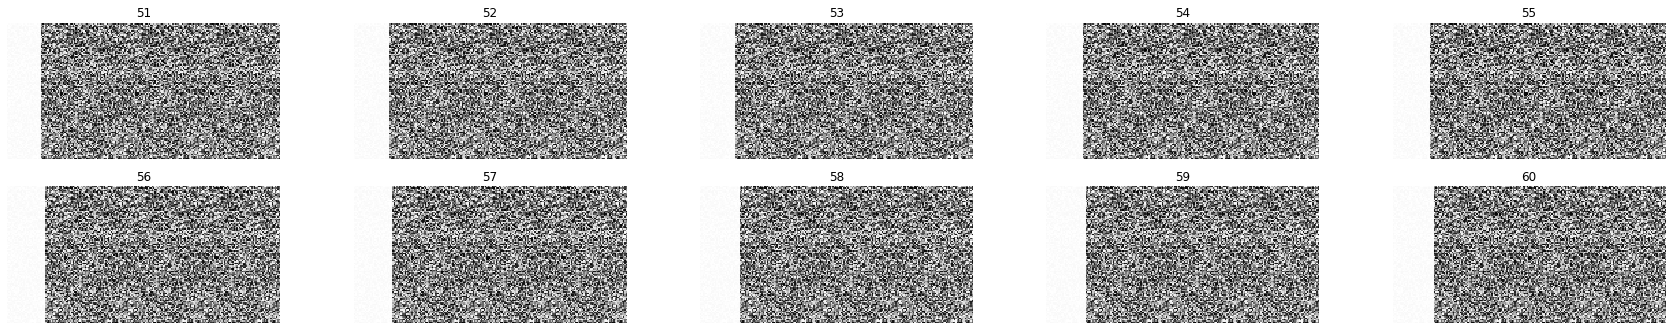

In [23]:
solp = Model(model.inputs, model.layers[0].output)
solp_features = solp.predict(np.array([sirds])).reshape(200,100,200)
show_features(solp_features, init=max(0, pred_disparity-5), end=min(199, pred_disparity+5)) 

At first glance, does not see any that allow select the correct disparity. Only noise for us.

We can show the feature maps with the expected weights of 50% of transparency:

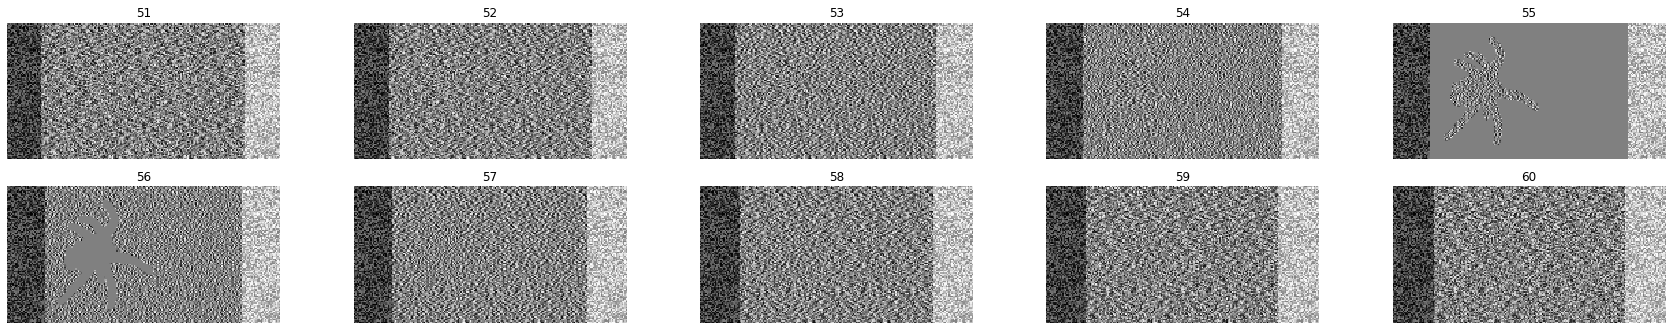

In [24]:
expected_solp = keras.models.clone_model(solp)
expected_solp.layers[1].set_weights(np.array([[0.5], [-0.5]]))
solp_features = expected_solp.predict(np.array([sirds])).reshape(200,100,200)
show_features(solp_features, init=max(0, pred_disparity-5), end=min(199, pred_disparity+5)) 

Here, the correct disparity feature map is clear: the feature map 55 show a clear silhouette.

We can think that the network have learnt to identify the correct disparity not only using one feature map but using a set of feature maps from the solp layer. We can check this computing the feature importante of each feature map replacing each one by noise and measuring the degradation of the prediction.

We will do it using 300 random samples from the real images dataset and measuring the importante of the feature maps but taking into account the distance of each feature map to the correct disparity factor. Is expected that the features near to disparity factor will be more imporants, but it could be interesting to see if other features more distant from the disparity factor are important too.

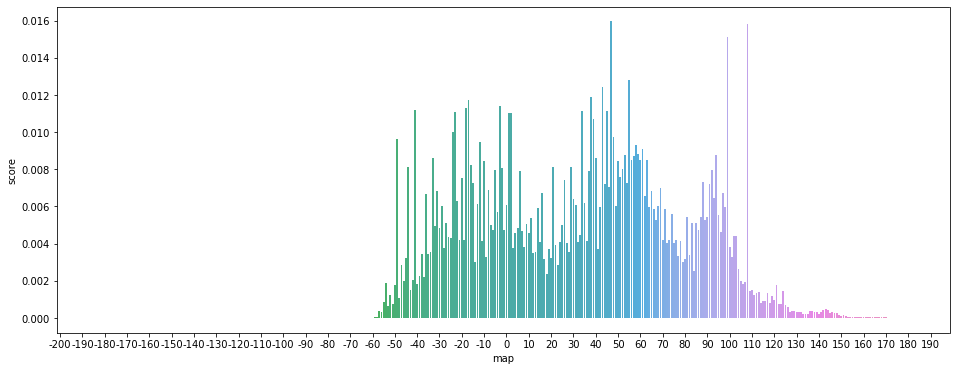

In [7]:
gen = CommonImagesGenerator('../data/fake_heatmaps/', batch_size=1)

distance_scores = np.zeros((400,))
for i in range(300):
    print(i)
    batch = gen.__getitem__(0)
    sirds, _, disparity = batch[0][0], batch[1][0], np.where(batch[1][0] == 1)[0][0]
    
    scores = get_sample_feature_maps_importance(model, sirds, 1, window=0)
    
    distance_scores[200-disparity:(400-disparity)] += scores

distance_scores /= 300

# plot a bar chart with the scores
plt.figure(figsize=(16, 6))
fig = sns.barplot(x='map', y='score', data=pd.DataFrame({'map': list(range(-200, 200)),
                                                   'score': distance_scores}))
new_ticks = [str(i) for i in range(-200, 201)]
plt.xticks(range(1, len(new_ticks), 10), new_ticks[::10])
plt.show()

As we can see, no only the disparity factor feature map and those nearby to it are importants.

This result leave a open question related with the interpretability of the neural networks and specially with the diffult to understand the high performance of deep learning models event when the problem is not complex.